# GWAS Prediction

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch
from scipy.stats import wilcoxon, ttest_rel, ranksums
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [3]:
def get_covariates(metadata, gene_lists):
    # create covariates from pops
    covariates = []
    for i in range(0, 22):
        #print(i)
        covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                       index = gene_lists[i],
                                       columns = ['genesize',
                                                  'log_genesize',
                                                  'genedensity',
                                                  'log_genedensity',
                                                  'inverse_mac',
                                                  'log_inverse_mac'])
                          )
    covariates = pd.concat(covariates)
    return covariates

### Load Embeddings

In [4]:
def get_embeddings(emb_name):
    emb_path = '../data/embeddings/'+emb_name+'.tsv'
    emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
    return emb

### Load GWAS MAGMA Scores

In [5]:
def load_magma(trait, covariates):
    magma = pd.read_csv('../data/input/GWAS/'+trait+'.genes.out', delim_whitespace=True)
    magma = magma.merge(covariates, left_on = "GENE", right_index = True)
    return magma

### Project Y to LY

In [6]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [7]:
def project_Y(Ls, magma, gene_lists):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res, gene_lists):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

### Merge Data

In [8]:
def prepare_data(trait, emb_name):
  sigmas, metadata, gene_lists = munge_sigma('../data/input/GWAS/'+trait+'.genes.raw')
  covariates = get_covariates(metadata, gene_lists)
  
  emb = get_embeddings(emb_name)
  
  magma = load_magma(trait, covariates)
  
  # Add Ls
  Ls = compute_Ls(sigmas, magma.ZSTAT)
  magma = magma.merge(project_Y(Ls, magma, gene_lists))
  
  # Merge everything
  data = magma.merge(emb, left_on = "GENE", right_on = "gene_id")
  dict = {"sigmas": sigmas, "metadata": metadata, "gene_lists": gene_lists, "covariates": covariates, "embeddings": emb, "Ls": Ls}
  return data, dict

## Regression

Split by Chromosomes.

In [9]:
def regression_chrom_cv(dt, emb_cols, Ls, gene_lists):
    cv_results = []
    
    for chrom in range(1,23):
        reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        
        # Null model (covariates only)
        mod_null = reg_null.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb_cols, axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred_null = mod_null.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb_cols, axis=1),
        )
        
        # Full model
        mod_full = reg_full.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred_full = mod_full.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        )
    
        results_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
        results_chrom['pred_LY_null'] = pred_null
        results_chrom['pred_LY'] = pred_full
    
        cv_results.append(results_chrom)
        #print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY_null)[0]**2}")
        #print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY)[0]**2}")
    
    #print()
    
    cv_results = pd.concat(cv_results)
    cv_results = cv_results.merge(project_Y_back(Ls, cv_results, gene_lists))

    null_r2 = scipy.stats.pearsonr(cv_results.ZSTAT, cv_results.pred_null)[0]**2
    full_r2 = scipy.stats.pearsonr(cv_results.ZSTAT, cv_results.pred)[0]**2
    print(f"Overall R2 (null): {null_r2}")
    print(f"Overall R2: {full_r2}")

    return cv_results, null_r2, full_r2

In [10]:
def get_results(traits, model_names):
    results = []
    for trait in traits:
        print("# Trait:", trait)
        
        for model in model_names:
            print("## Model:", model)
            data, metadata = prepare_data(trait, model)
            emb_cols = metadata["embeddings"].columns.to_list()
            Ls = metadata["Ls"]
            gene_lists = metadata["gene_lists"]
            #reg_results = regression_chrom_cv(data, emb_cols, Ls, gene_lists)
            cv_results, null_r2, full_r2 = regression_chrom_cv(data, emb_cols, Ls, gene_lists)
            
            r2_null=[]
            r2_full=[]
            for i in range(1,23):
                df = cv_results.query("CHR == @i")
                r2_null.append(R2Score().update(torch.tensor(df["pred_null"].values), torch.tensor(df["ZSTAT"].values)).compute().numpy())
                r2_full.append(R2Score().update(torch.tensor(df["pred"].values), torch.tensor(df["ZSTAT"].values)).compute().numpy())
            
            res = {'trait': trait, 'name': model, 'null_r2': null_r2, 'full_r2': full_r2, 'cv_results': cv_results, 'full': np.array(r2_full), 'null': np.array(r2_null)}
            results.append(res)
            print()
    return results

## Plotting

In [11]:
def r2_per_chrom(reg_results):
    print("Per chrom R2 (full):")

    per_chrom_r2 = []
    for i in range(1, 23):
        res_tmp = reg_results.query("CHR == @i")
        r2 = scipy.stats.pearsonr(res_tmp.ZSTAT, res_tmp.pred)[0]**2
        per_chrom_r2.append(r2)
        print(r2)
    
    chromosomes = list(range(1, 23))
    df = pd.DataFrame({'Chromosome': chromosomes, 'R2': per_chrom_r2})
    
    # Plot R^2 values across chromosomes
    return (ggplot(df, aes(x='factor(Chromosome)', y='R2')) +
     geom_bar(stat='identity') +
     labs(title='R^2 Across Chromosomes', x='Chromosome', y='R2'))

In [12]:
# scatter plot (of predicted vs. true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

In [13]:
def scatterplot_model(res_df, modelname):
    model = 'Omics_d256'
    plot_data = res_df[res_df['name'] == model]
    p = ggplot(plot_data, aes('null_r2', 'full_r2', color='trait')) + geom_point() + geom_abline(intercept = 0, slope = 1) + ggtitle(model)
    return p
    
def scatterplot_all_models(res_df):
    p = ggplot(res_df, aes('null_r2', 'full_r2', color='trait')) + facet_wrap('name') + geom_point() + geom_abline(intercept = 0, slope = 1)
    return p

## Comparing Results

In [14]:
# plot r2 score
def compare_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None, r2_null_name="r2_null", r2_full_name="r2_full"):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        r2_null_name: np.array(r2_null),
        r2_full_name: np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=[r2_null_name, r2_full_name], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()
    
    w_stat, w_p_value = wilcoxon(r2[r2_null_name], r2[r2_full_name])
    #print(f'Wilcoxon p-value: {w_p_value:.4f}')
    
    # Add p-value to the plot
    p1 = p1 + labs(subtitle=f'p = {w_p_value:.4f}')
    
    return p1 #, p2

In [15]:
def compare_r2_across_models(model_results):
    data_table = pd.DataFrame()

    for model_result in model_results:
        model_name = model_result['name']
        delta_r2_column = f'delta_r2_{model_name}'
        data_table[delta_r2_column] = model_result['full'] - model_result['null']

    # Melt the DataFrame
    data_table = pd.melt(data_table, var_name='model', value_name='delta_r2')

    # Plot using plotnine
    return (ggplot(data_table, aes(x='model', y='delta_r2')) +
            geom_boxplot())

# Run

In [16]:
from os import walk
traits = []
filenames = next(walk("../data/input/GWAS"), (None, None, []))[2]  # [] if no file
for f in filenames:
    if (f.split(".genes.")[1] == "raw"):
        traits.append(f.split(".genes.")[0])
traits

['LDL_direct',
 'Calcium_30680',
 'HDL_cholesterol',
 'Lipoprotein_A',
 'Apolipoprotein_B',
 'Direct_bilirubin',
 'Vitamin_D',
 'HDL',
 'RBC',
 'Testosterone',
 'Alanine_aminotransferase',
 'Triglycerides',
 'Mean_corpuscular_haemoglobin',
 'Total_bilirubin',
 'IGF-1',
 'LDL_direct_adjusted_by_medication',
 'C-reactive_protein',
 'Phosphate',
 'Red_blood_cell_erythrocyte_count',
 'Albumin',
 'MCH',
 'Creatinine',
 'Cholesterol',
 'LDLC',
 'Total_protein',
 'Urate',
 'Apolipoprotein_A',
 'SHBG',
 'Glucose',
 'Calcium_100024']

In [17]:
models = ["Omics_d256", "GTEx_PCA_d64"]

In [18]:
#traits = traits[:4]
results = get_results(traits, models)

# Trait: LDL_direct
## Model: Omics_d256
Overall R2 (null): 0.047332683664869736
Overall R2: 0.0601150973315238

## Model: GTEx_PCA_d64
Overall R2 (null): 0.04752407087597029
Overall R2: 0.05753646453664864

# Trait: Calcium_30680
## Model: Omics_d256
Overall R2 (null): 0.04147051467410333
Overall R2: 0.05377563031517959

## Model: GTEx_PCA_d64
Overall R2 (null): 0.04127034966999407
Overall R2: 0.05351167420874918

# Trait: HDL_cholesterol
## Model: Omics_d256
Overall R2 (null): 0.08232776249204325
Overall R2: 0.09524026030438075

## Model: GTEx_PCA_d64
Overall R2 (null): 0.08496933277334742
Overall R2: 0.09806421815668075

# Trait: Lipoprotein_A
## Model: Omics_d256
Overall R2 (null): 0.006543239697407168
Overall R2: 0.0053398656434777815

## Model: GTEx_PCA_d64
Overall R2 (null): 0.006680198284476393
Overall R2: 0.006558484540170552



In [19]:
res_df = pd.DataFrame.from_records(results)[['trait', 'name', 'null_r2', 'full_r2']]
res_df

,trait,name,null_r2,full_r2
0,LDL_direct,Omics_d256,0.047333,0.060115
1,LDL_direct,GTEx_PCA_d64,0.047524,0.057536
2,Calcium_30680,Omics_d256,0.041471,0.053776
3,Calcium_30680,GTEx_PCA_d64,0.041270,0.053512
4,HDL_cholesterol,Omics_d256,0.082328,0.095240
5,HDL_cholesterol,GTEx_PCA_d64,0.084969,0.098064
6,Lipoprotein_A,Omics_d256,0.006543,0.005340
7,Lipoprotein_A,GTEx_PCA_d64,0.006680,0.006558


## General Comparison

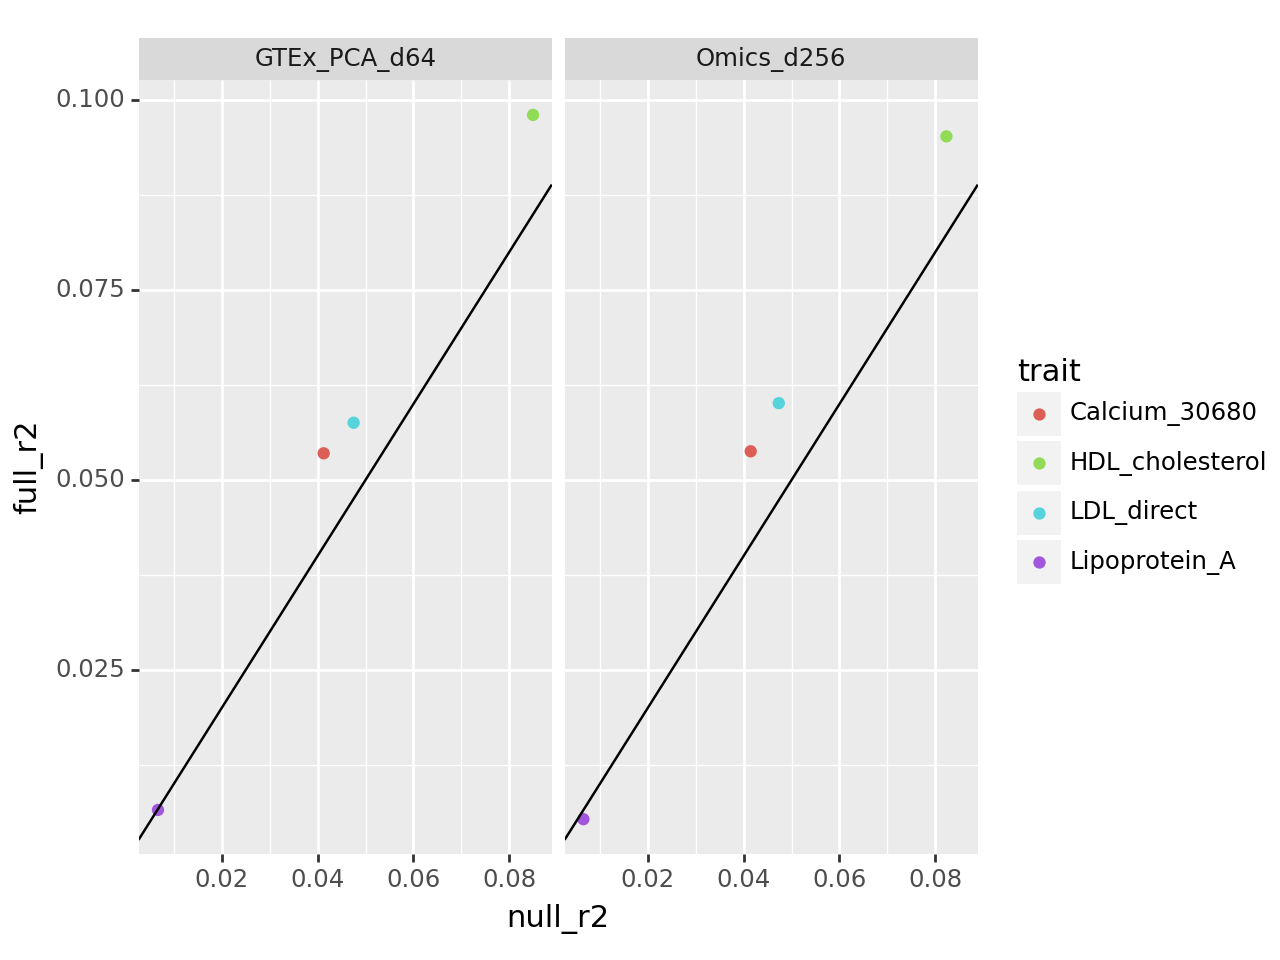

<Figure Size: (640 x 480)>

In [20]:
scatterplot_all_models(res_df)

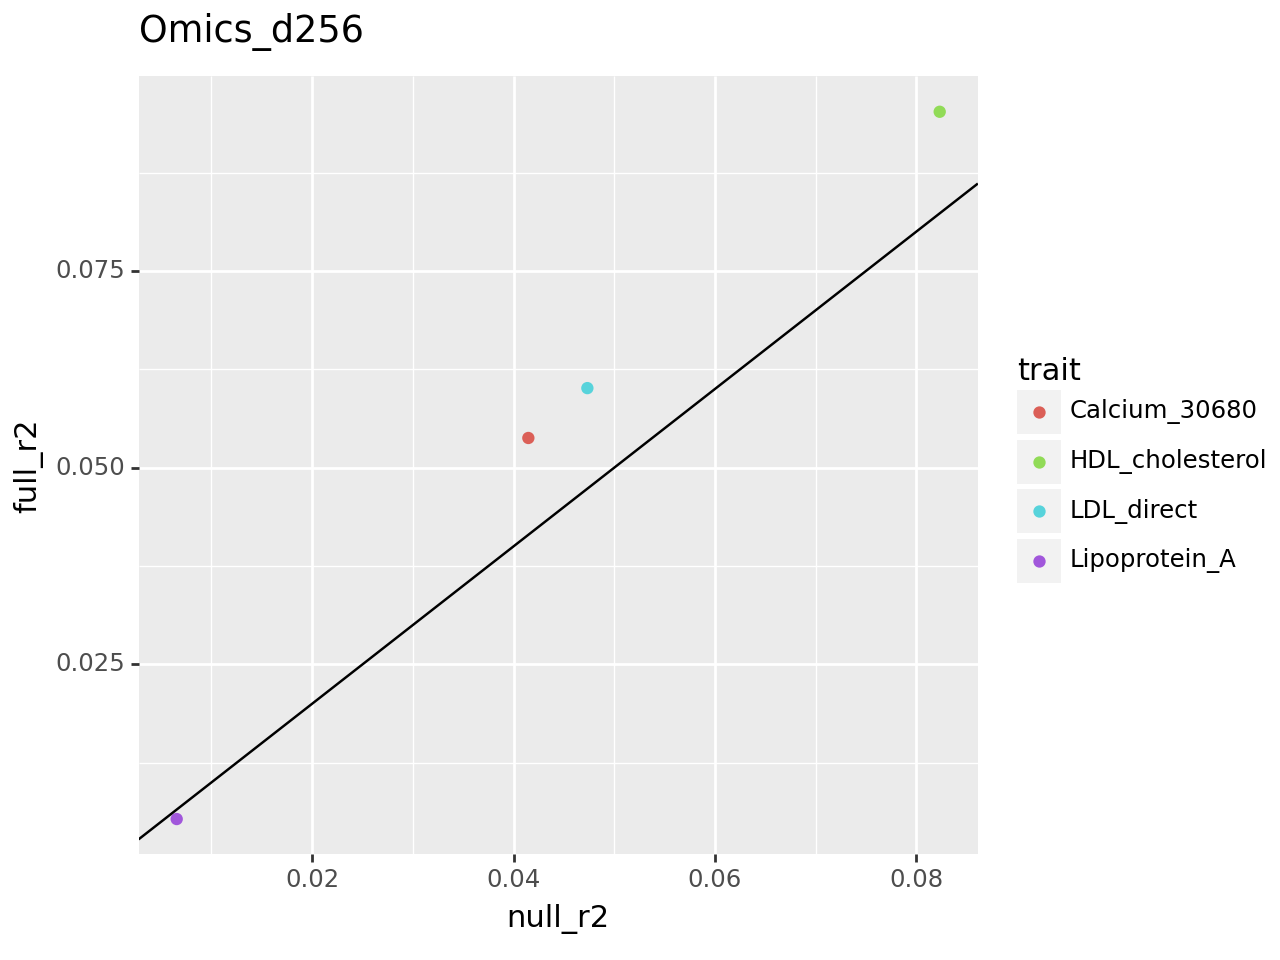

<Figure Size: (640 x 480)>

In [21]:
scatterplot_model(res_df, "Omics_d256")

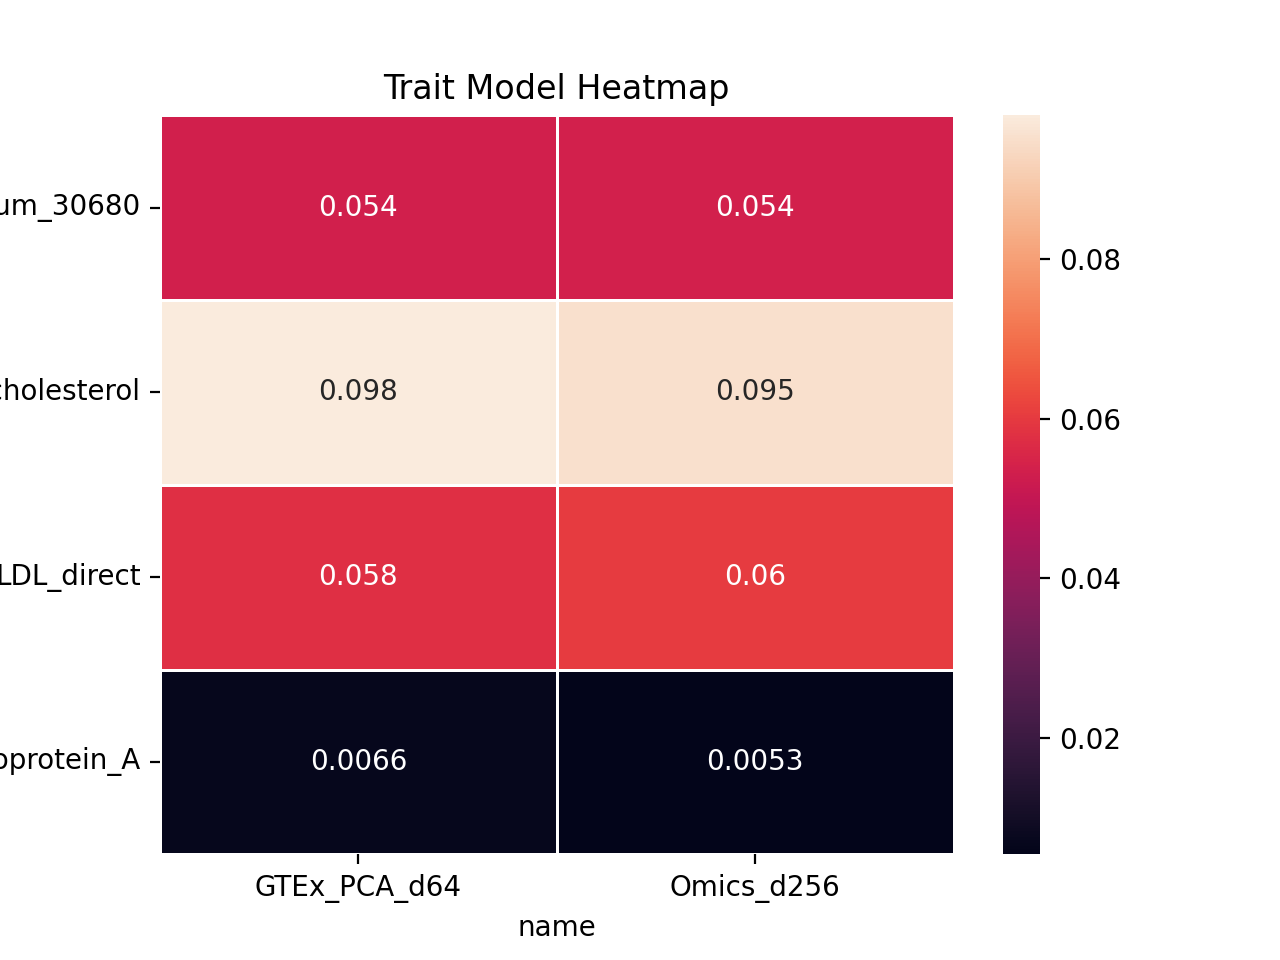

In [42]:
heatmap_data = res_df.pivot(index='trait', columns='name', values='full_r2')
sns.heatmap(heatmap_data, annot=True, linewidths=.5)
plt.title('Trait Model Heatmap')
plt.show()

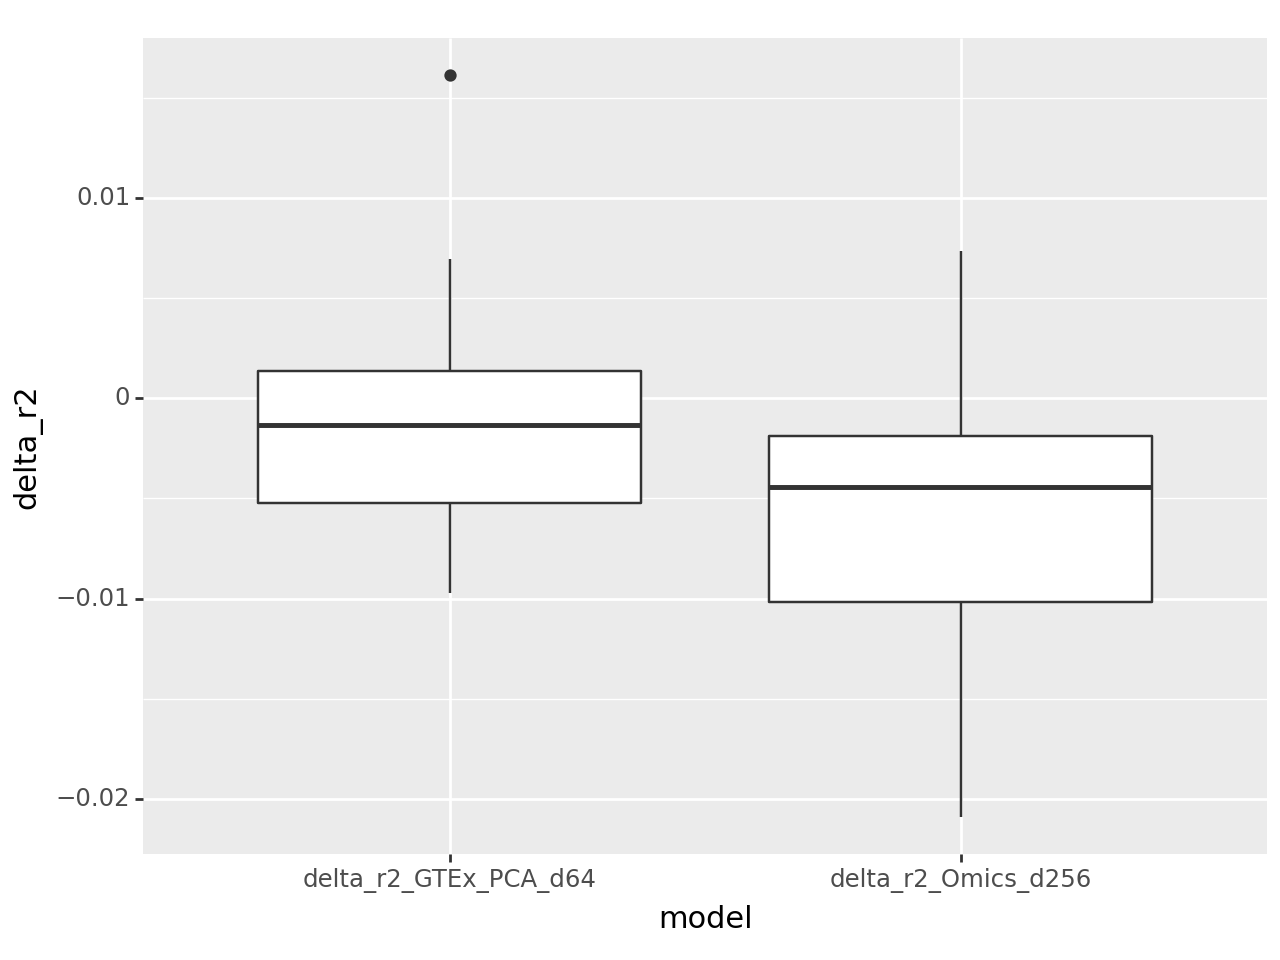

<Figure Size: (640 x 480)>

In [43]:
compare_r2_across_models(results)

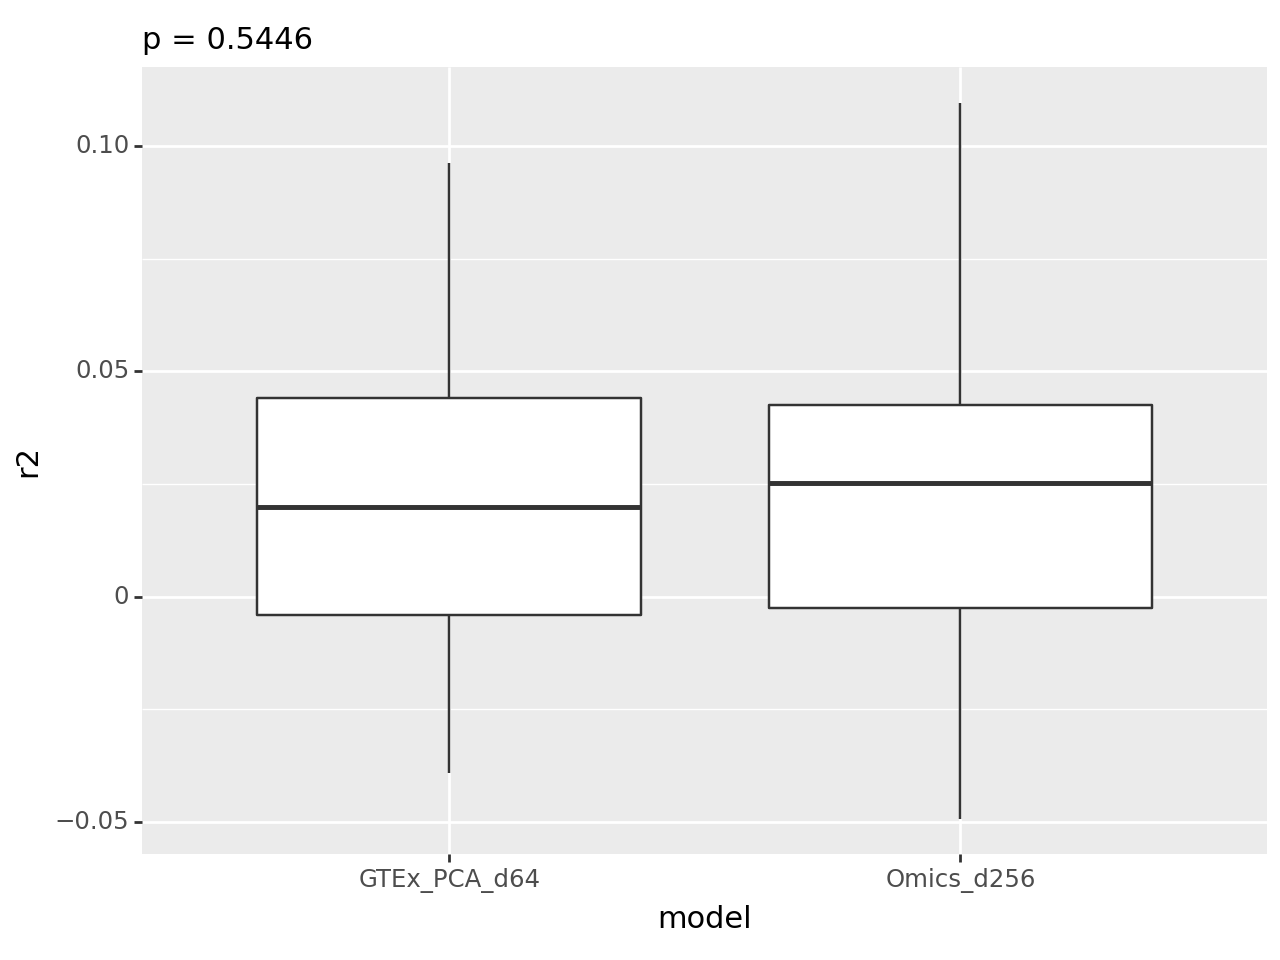

<Figure Size: (640 x 480)>

In [44]:
compare_r2(r2_null_name=results[0]["name"], r2_null=results[0]["full"], r2_full_name=results[1]["name"], r2_full=results[1]["full"])

## Omics

In [47]:
res_omics = results[0]['cv_results']

Per chrom R2 (full):
0.014235136233660635
0.06344675601877257
0.04459058993338424
0.05792775420867813
0.010516513901895903
0.23426423482317718
0.08196202719390246
0.024592798848315212
0.018758632109189727
0.018720716654670344
0.11197777132340028
0.10593007982682738
0.034351001931078075
0.06165108477042907
0.014559541483400436
0.034949020181586
0.06917282968338057
0.043278405029505695
0.04309503117998242
0.09484277529815822
0.012089673217966793
0.03973332272770227


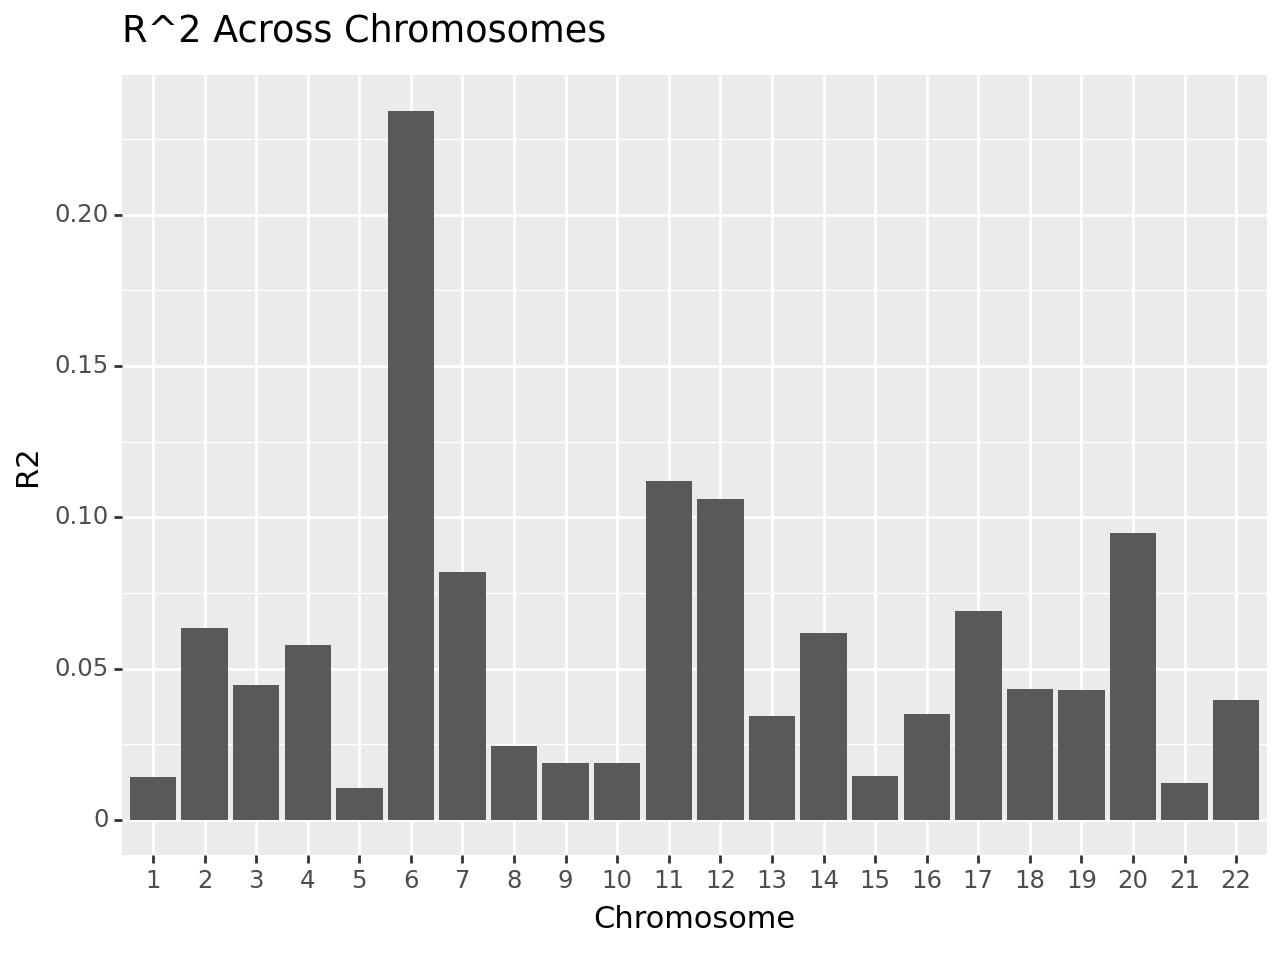

<Figure Size: (640 x 480)>

In [48]:
r2_per_chrom(res_omics)

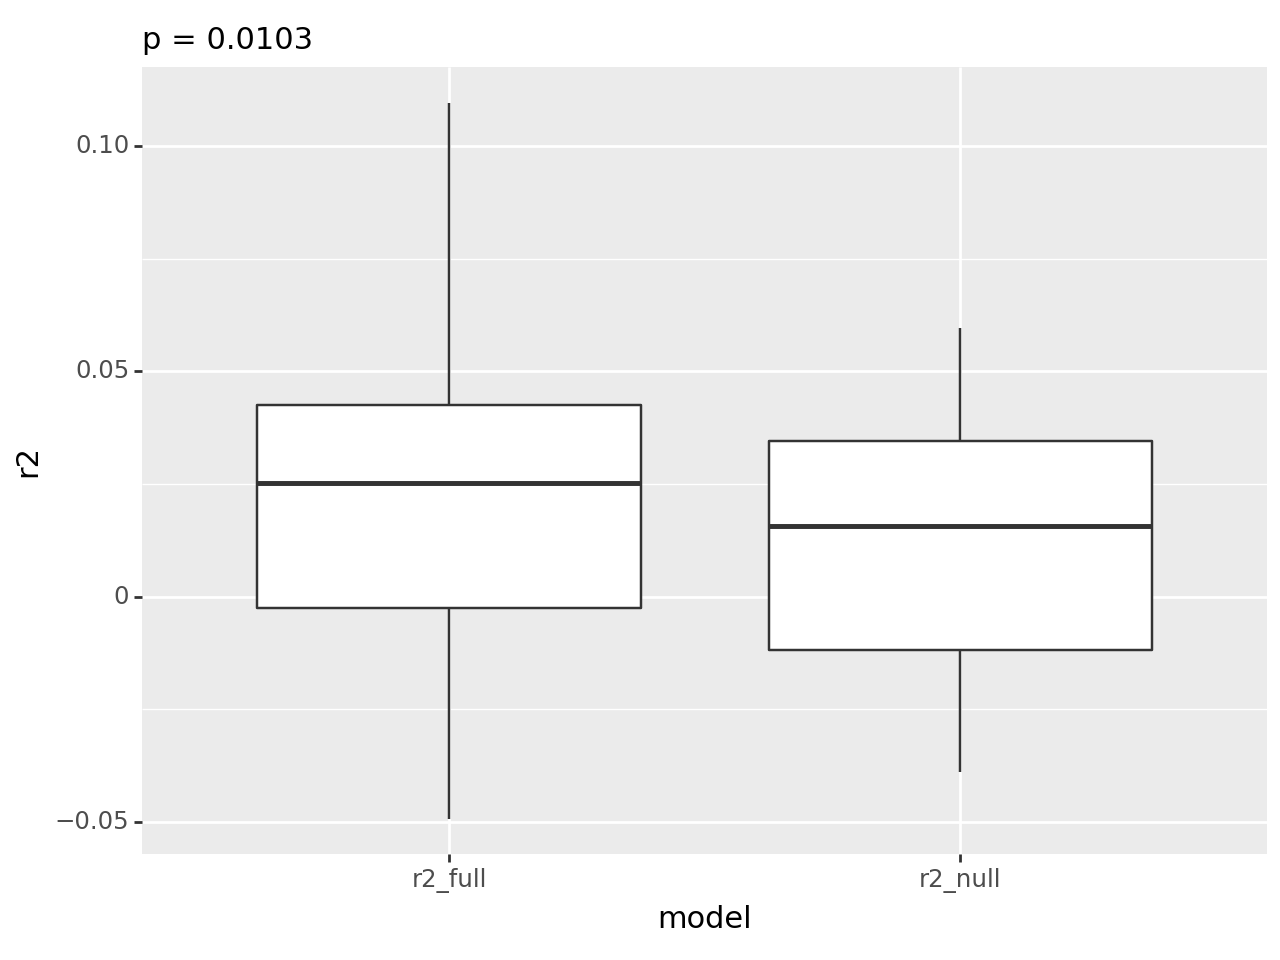

<Figure Size: (640 x 480)>

In [49]:
compare_r2(res_omics)

## GTEx PCA

In [51]:
res_gtex_pca = results[1]['cv_results']

Per chrom R2 (full):
0.016431020459186683
0.04193203809024064
0.04563605401247834
0.014818731888982485
0.018956330025059608
0.21359437015430702
0.07403994711130113
0.023930436147112502
0.035540127032554686
0.01875233307159295
0.10142636169660187
0.0992105938938574
0.04593855749748627
0.06639674870870184
0.019383854920680413
0.03173668793767533
0.059400539598901354
0.01574005258830214
0.03714334951012986
0.09011510196100495
0.01736887419176714
0.009171461357901079


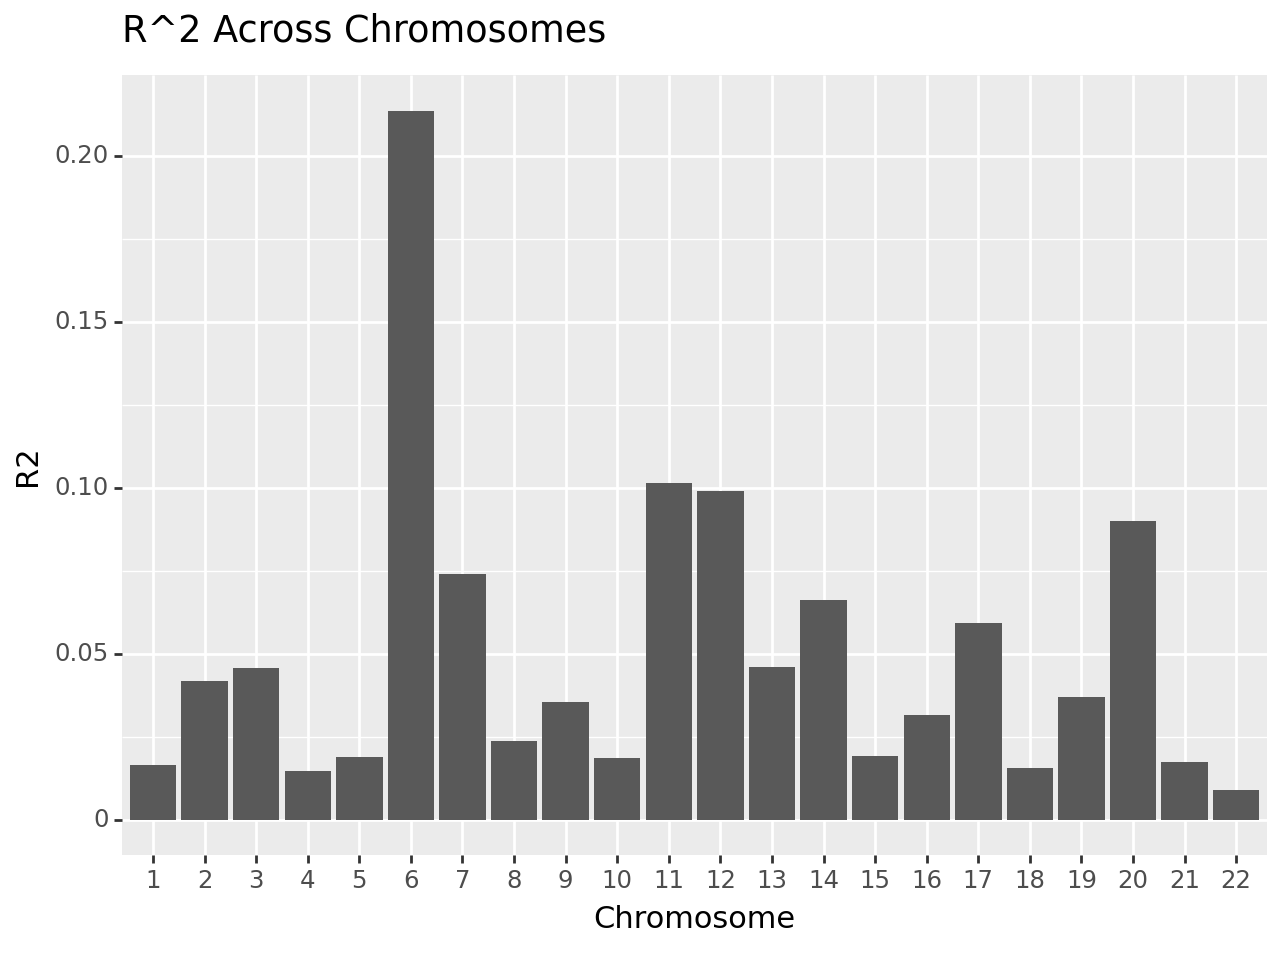

<Figure Size: (640 x 480)>

In [52]:
r2_per_chrom(res_gtex_pca)

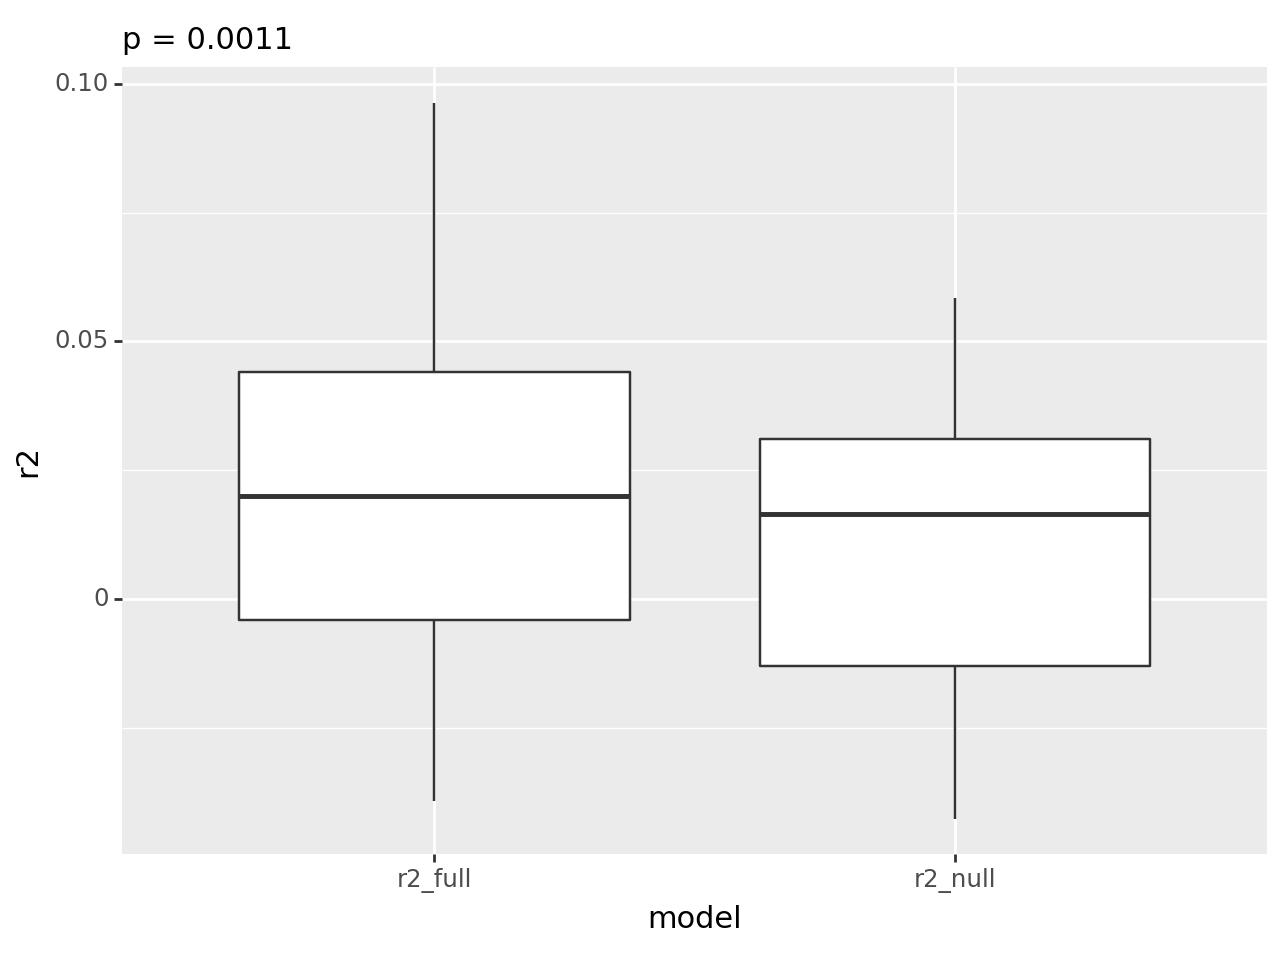

<Figure Size: (640 x 480)>

In [53]:
compare_r2(res_gtex_pca)